# Segregation of People into Like-Minded Groups [Python MeetUp Ljubljana February 2019]

## Introduction

In personality psychology, there is an interesting idea. And this is, that we people put ourselves in the situations, which we like. The people that are agreeable, usually end up in the situations, where they are nice and comsy and fluffy people. Disagreeable, on the other hand, tend to put themsleves in the situations that are competitive and with no safe spaces. 

This is one the one hand problem in science. It is how to get a more representitive sample. Because, if you want to research prisons, you get more agreesive, socially dominating narcisits than a general population (Carnahan and McFarland, 2007). If you research psychology student, a sample will be a mot more empatich, compared to economists, which are more selfish (Frank et al., 1993).

But on the other hand, it can be a great way to navigate the social situations. There are a type of people, one can find in the shopping mall during the sales, which is different than one can find in the opera, which is again different that one can find in a Python meetup, which is different, than one can find in a rock concert. 

And the stereotypes can in same way be very helpful in navigating different communities (though in some cases, they can be wrong). 

Sure, each one of us have the identity made out of many connected parts. I mean, I am an economists, a cognitive scientist, a programmer, a student, a researcher, an INTP, an introvert, a fanfictionar, former Toastmasters, former Erasmus and many more. But there is nothing that would go against that. Each part can be though as a different subpersonality inside one person (sort of like ego, id and superego in Freud's theory, but a bit more varied and numerous). 

So what is going to be investigated is this "research" is going to be, a bit of investigation of how little it is necessary to make people go into like-minded groups. 

The original model and the inspiration of changes came from the following economics article (can also be found on https://www.uzh.ch/cmsssl/suz/dam/jcr:00000000-68cb-72db-ffff-ffffff8071db/04.02_schelling_71.pdf ):

*  Thomas C. Schelling (1971) Dynamic models of segregation, The Journal of Mathematical Sociology, 1:2, 143-186, DOI: 10.1080/0022250X.1971.9989794 

## Assmuption

In order for the model to work, you will have to agree with one assumption. Which sort of grows from the idea that choose our own enviornments. If I can't get you to agree with the assumptions, then nothing further down will not be applicable to you. 

The assumption is: When we are sourunded by people, that are not like us, we choose to leave and try something else. 

You don't even have to agree, that everybody is like that. Something that will be researched later on. It just needs to be something that you think is generally relevant. 

Sure, not every time, that I am surounded by people, that are not like me, I want to leave. But a lot of times I do. Who had not been stuck in a boring lecture or religious service, you did not want to take a part in? But there are groups of people, that I can not imagine spending any time with. Like the people that go to 'seminars' for pyramid scemes, or hare krisha or even these 'highly-extroverted-financial-seminars-disguisted-as-personal-development'. (If you feel insulted, I have the right no not associalte with these people, and you have the right to not associate with me - blame my low agreeablness :) ).

So, basically, I just need you to agree, that when you are stuck with people that make you uncofortable, you will not associate with them in the future (if possible). 

## Importing Libaries

So let me first start by importing the libaries, that I am going to be using here. Let me first start by importing the necessary things from mesa, which is the libary, that I am using for agent based modeling. 

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import SingleGrid

Next I need to upload the libaries, necessary for vizualizations of the results. 

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
import networkx as nx

And the last is to import the other random libaries, which are helping me. 

In [3]:
import random
from collections import Counter
import numpy as np
from scipy.stats import ttest_ind

## Defining the Model

So what kind of model are we talking about here? Well, the original model was researching the segregation of black and white housing in America. Considering, that the article was written in 1971, you can imagine it was a hot topic back then. 

But the model can be used for any kind of segregation, not just in race. It can help explan, when the jobs are staying mostly male (you know, truck drivers) or mostly female (teachers, I think?), without invoking a great opression by the whatever group they come up with next (I don't understand third-wave feminism, so I guess that means I must be prevliged from my point of view?). Or it can be used to understand, why there are mostly programmers here. Or why people choose the mayor of their study. And any other community building type. 

If you really think about the model (something, I think I will run our of energy before coming there), it can also explan why some people leave and other come. 

Instead of the normal networks, that are usually used to study this, we are going to use space. One, to pay homage to the original article, it is easier to vizulize and I am sure, there is a relationship, that the closer you are to a person, the more time you spend in a similar place (though, the correlation is probablly far from perfect). 

The model has a couple of different parameters. The main ones are the size of the space and the number of agents in this space. The model only works, if the agents have someplace to move, so put the number of agents as lower then the multiplication of height and weight. 

In [4]:
height = 25
weight = 25
number_of_agents = 500

The next one are threshold and standard deviation. They are the atributes telling us, how sensitive agents are to being near people, that are different then them. When the procent of people in the group, that is not their own, reaches the threshold, then the person wants to move away. The standard deviation tells us, how much of a personal difference is there. If standard deviation is not 0, then the threshold is treated as an avreage threshold. 

In [5]:
threshold = 0.6
sd = 0.0

And then we name the groups, because this way it is more fun. I decided on the Vim and Emacs for the first example, because of the recent experience I had at work. I was with two co-workers, and apperentlly me opening one of them lead me to be in the middle of the... disagreement, I guess? And the one tried to convince me, that his choice is better. 

I really thought that this is just a years old internet meme. I did not know that actually happened. 

In [6]:
possible_groups = ["Vim", "Emacs"]

So first we are difining out agents. We have two functions here, one to create them, and the other, which happens each turn. 

In [7]:
class Programmer(Agent):
    
    def __init__(self, unique_id, model, threshold, sd, possible_groups):
        #function for creating the agent
        super().__init__(unique_id, model)
        #here we define in which group the agent belongs and how sensitive agent is to people outside of their group
        self.group_membership = random.choice(possible_groups)
        self.threshold = random.gauss(threshold, sd)
        if self.threshold > 1:
            self.threshold = 1
        if self.threshold < 0:
            self.threshold = 0
        
    def step(self):
        #function, which happens every turn
        #first, when the agent is picked, he checkes who the 8 neighbors around him are
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        #next he gets the groups each of the eight agents belong to
        nearby_people = [[element.group_membership for element in self.model.grid.get_cell_list_contents(position)] for position in possible_steps]
        nearby_people = [element[0] for element in nearby_people if element]
        #next the agent calculates the number of people nearby (because in the cornets is is not 8, but 3)
        #but also, some spaces can be empty and these are not counted
        number_of_nearby_people = len(nearby_people)
        #and it also keeps track of how many people in each group are around them
        groups_of_nearby_people = Counter(nearby_people)
        #then for each group, they check, if any group (sans its own) reaches the threshold,
        #and if it does, it moves to a random empty place
        for group in groups_of_nearby_people:
            if group != self.group_membership:
                if groups_of_nearby_people[group]/number_of_nearby_people > self.threshold:
                    self.model.grid.move_to_empty(self)

After defining the agents, we also need to define the model. 

In [8]:
class SpaceModel(Model):
    def __init__(self, N, width, height, threshold, sd, groups):
        #creating the model
        self.num_agents = N
        #Random Activation means, that each turn, each agent is going to be activated in random order
        self.schedule = RandomActivation(self)
        #this creates a grid - SingleGrid means that there can be only one agent on each place 
        #(but there is also a MultipleGrid, which allows more agents in one space)
        #the last False is to not wrap it - going to the far right does not make you appear in the far left
        self.grid = SingleGrid(width, height, False)
    
        #there the agents are created and places in the sceduler and in the grid
        for i in range(N):
            a = Programmer(i, self, threshold, sd, groups)
            self.schedule.add(a)
            self.grid.position_agent(a, x=i//width, y=i%width)
            
    def step(self):
        #this one just said, that each time, do whatever the scedule tells you
        self.schedule.step()

Now, that we have defined the model and the agent, we can run it. The parameters for the model were set in the beginning, so here we can just call them. 

In [9]:
model = SpaceModel(number_of_agents, height, weight, threshold, sd, possible_groups)

Now the model just exist. We can not made the agents do anything else, we just placed them in the board. (I mean, whoever cam up with idea, that we are just one simmulated universe of the highly advanced spieces have prbablly never done any modeling by themslves - there is a thing called a Bonini paradox, which does say, that if you want to model to help you explan reality, it has to be simpler than reality).  

So what this does, it takes the numpy array or array, and then replace them with different numbers for different groups (-1 being empty) and vizulizes it. 

As you can see below, the empty space is located at the very bottom (the purple), but othervise the groups seems to be pretty random. 

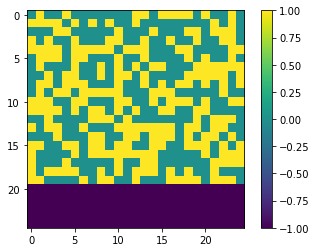

In [10]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
agent_counts = agent_counts-1
for cell in model.grid.coord_iter():
    agent_present, x, y = cell
    if agent_present:
        agent_counts[x][y] = possible_groups.index(agent_present.group_membership)
plt.imshow(agent_counts)
plt.colorbar()

One crude metric, that can be used here, is to calculate the ratio of neighbors, that belong in the same group. 0 would mean that each of theym they are alone, in the sea of weirdness, the 1 would be, that each is only surovded with their own kind. The completlly random distribution, I would expect around 0.5

The calculations, just like before, ignore the empty space. 

In [11]:
clustering_coefficient = []
for programmer_object, x, y in model.grid.coord_iter():
    element = agent_counts[x][y]
    if element == -1:
        continue
    neighbors = model.grid.get_neighborhood((x, y), moore=True, include_center=False)
    neighbors = [agent_counts[x][y] for x, y in neighbors]
    same_neighbors = sum([value for key, value in Counter(neighbors).items() if key == element])
    all_neighbors = sum([value for key, value in Counter(neighbors).items() if key != -1])
    if all_neighbors:
        clustering_coefficient.append(same_neighbors/all_neighbors)
sum(clustering_coefficient)/len(clustering_coefficient)

0.4914333333333333

And because I will need this function a lot down below, I will put it in a function (which gets is just by putting a model in, so it also have some of the code, that I used for vizualizing).

In [12]:
def get_clustering(current_model, possible_groups):
    agent_counts = np.zeros((current_model.grid.width, current_model.grid.height))
    agent_counts = agent_counts-1
    for cell in model.grid.coord_iter():
        agent_present, x, y = cell
        if agent_present:
            agent_counts[x][y] = possible_groups.index(agent_present.group_membership)
    clustering_coefficient = []
    for programmer_object, x, y in current_model.grid.coord_iter():
        element = agent_counts[x][y]
        if element == -1:
            continue
        neighbors = model.grid.get_neighborhood((x, y), moore=True, include_center=False)
        neighbors = [agent_counts[x][y] for x, y in neighbors]
        same_neighbors = sum([value for key, value in Counter(neighbors).items() if key == element])
        all_neighbors = sum([value for key, value in Counter(neighbors).items() if key != -1])
        if all_neighbors:
            clustering_coefficient.append(same_neighbors/all_neighbors)
    return sum(clustering_coefficient)/len(clustering_coefficient)

Next, the model is going to go through some of the changes. In this case, each agents gets to have a decision 100 times. 

In [13]:
for i in range(100):
    model.step()

So again, vizualizing the model, so we can see the changes. And as you can see from the picture below, it looks a lot more clustered. 

In [14]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
agent_counts = agent_counts-1
for cell in model.grid.coord_iter():
    agent_present, x, y = cell
    if agent_present:
        agent_counts[x][y] = possible_groups.index(agent_present.group_membership)

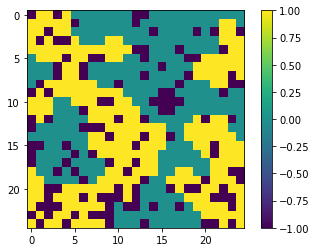

In [15]:
plt.imshow(agent_counts)
plt.colorbar()

In [16]:
get_clustering(model, possible_groups)

0.8512976190476188

## Run the same model 100 times

So, in order to see, if this was just a random chance, it helps, to run a model multiple times. In this time, the model is going to be run 100 times, and the raito of same neighbord is going to be calculated each time. Then we can compute the statistics. 

In [17]:
starting_coefficients = []
ending_coefficients = []
for j in range(100):
    model = SpaceModel(number_of_agents, height, weight, threshold, sd, possible_groups)
    starting_coefficients.append(get_clustering(model, possible_groups))
    for i in range(100):
        model.step()
    ending_coefficients.append(get_clustering(model, possible_groups))

Let us first see the differences in the avreages. Eyeballing them, they seems quite extensive.

In [18]:
sum(starting_coefficients)/len(starting_coefficients)

0.4998126666666668

In [19]:
sum(ending_coefficients)/len(ending_coefficients)

0.8243752195172525

Then let us see the distributions on the same graph (after all, looking at only avreages can be misleading).

Text(0.5, 1.0, 'Distribution of ration of like minded people around them')

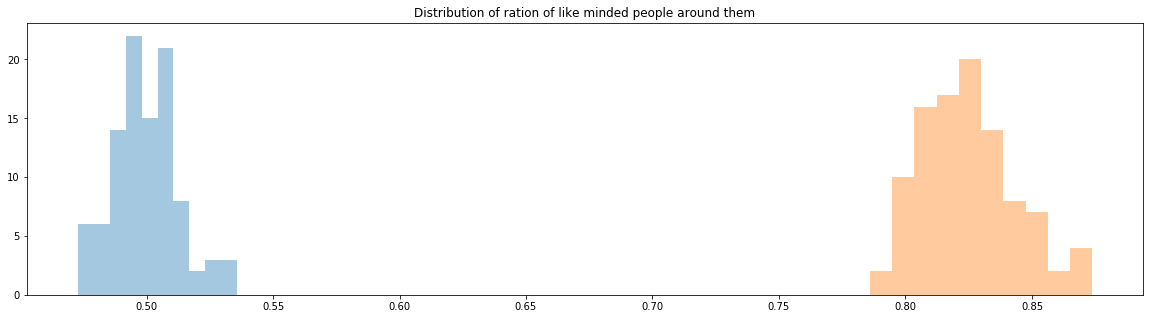

In [20]:
f = plt.figure(figsize=(20,5))
plot1 = f.add_subplot(1, 1, 1)
plot1.hist(starting_coefficients, alpha=.4)
plot1.hist(ending_coefficients, alpha=.4)
plot1.set_title("Distribution of ration of like minded people around them")

And on the end, there is also possible to calculate the t-test, to see what the difference is. 

In [21]:
ttest_ind(starting_coefficients, ending_coefficients, equal_var=False)

Ttest_indResult(statistic=-142.1994537275974, pvalue=6.83291333542273e-182)

And for practice, I tried to calculate, what the relevant effect size (Cohen.d) would be.

In [22]:
def cohen_d(x,y):
    x_length = len(x)
    y_length = len(y)
    dof = y_length + x_length - 2
    return abs(np.mean(x) - np.mean(y)) / np.sqrt(((x_length-1)*np.std(x, ddof=1) ** 2 + (y_length-1)*np.std(y, ddof=1) ** 2) / dof)

In [23]:
cohen_d(starting_coefficients, ending_coefficients)

20.110039602361358

These are (for social science) quite a large effects. 

## Different Thresholds

But sure, what the threshold is, is also an assumption. So here, I am going to check, if the agents behave differentlly, depending on how sensitive they are to the differences around them. I will go to the completly sensitive - they don't want anybody different around, to completlly insinsitive - they don't care.

In [24]:
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

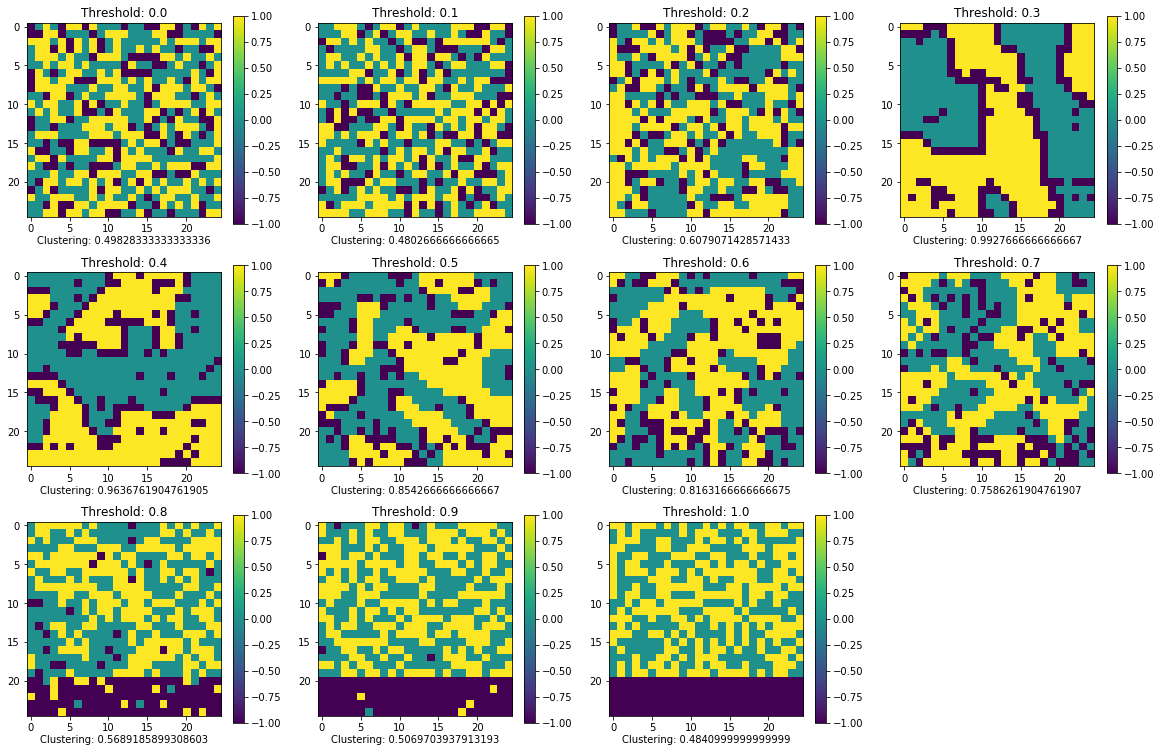

In [25]:
fig = plt.figure(figsize=(20,13))
for j, threshold in enumerate(thresholds):
    model = SpaceModel(number_of_agents, height, weight, threshold, sd, possible_groups)
    for i in range(100):
        model.step()
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    agent_counts = agent_counts-1
    for cell in model.grid.coord_iter():
        agent_present, x, y = cell
        if agent_present:
            agent_counts[x][y] = possible_groups.index(agent_present.group_membership)
    plt.subplot(3, 4, j+1)
    plt.imshow(agent_counts)
    clust = get_clustering(model, possible_groups)
    plt.text(12, 28, "Clustering: " + str(clust), horizontalalignment='center')
    plt.title("Threshold: " + str(threshold))
    plt.colorbar()

The results are pretty interesting. Well, one case is expected, and that is, if the person does not care whenever they are different people around them, then there is no change happening. The second, a bit more interesting thing is, that if they really don't want to be around different people, then they move around too much, and there is never enough people, to have a critical mass, to make a groups.

But I think the most interesting case is the one with the highest segregation. This is the case with people, that want to be the majority, but they are alright with some diversity. These are the groups, that (according to the model) lead to the higest segregation. But anything with the (wide) around 50-50 leads to the segregation.

## Standard Deviation

The next thing to check is, what if different people have a different levels of how comfortable they are with being around people different then them. The different threshold are taken from the bell distribution. 

In [26]:
threshold = 0.6
sd = 0.5

In [27]:
model = SpaceModel(number_of_agents, height, weight, threshold, sd, possible_groups)

In [28]:
for i in range(100):
    model.step()

In [29]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
agent_counts = agent_counts-1
for cell in model.grid.coord_iter():
    agent_present, x, y = cell
    if agent_present:
        agent_counts[x][y] = possible_groups.index(agent_present.group_membership)

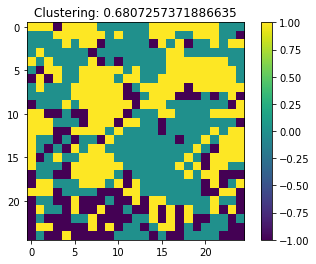

In [30]:
plt.imshow(agent_counts)
clust = get_clustering(model, possible_groups)
plt.title("Clustering: " + str(clust))
plt.colorbar()

There is less clustering, as there would be without this variability, but there is still clustering. 

## Multiple groups

So far, we have only been dealing with two groups. But what happens, when we deal with multiple groups. The first analysis is going to check, what happens, when the person simply does not want another group to be a majority. And the second one shows, what happens, when they don't want people different then them to be a majority.

Let us first start with the not wanting other group to be a majority. 

In [31]:
threshold = 0.6
sd = 0.0

In [32]:
all_colors = ["black", "white", "red", "blue", "yellow", "purple", "green", "orange", "brown", "grey"]

In [33]:
different_versions_of_groups = [
                                ["Men", "Women"], 
                                ["Python", "R", "SQL"], 
                                ["Arrow", "STARLabs", "DEO", "Legends"],
                                ["A", "C", "O", "N", "E"],
                                ["1", "2", "3", "4", "5", "6"],
                                ["Green", "Red", "Purple", "Yellow", "Orange", "Blue", "Brown"],
                                ["Ti", "Fi", "Si", "Ni", "Te", "Fe", "Se", "Ne"],
                               ]

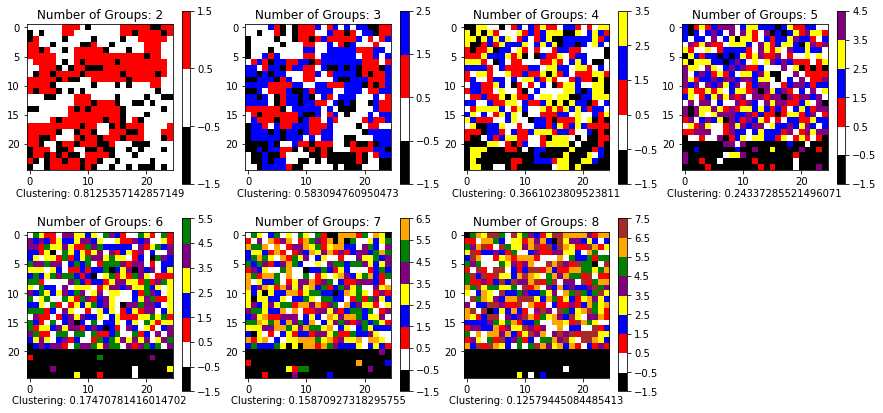

In [34]:
fig = plt.figure(figsize=(15,7))
for j, groups in enumerate(different_versions_of_groups):
    model = SpaceModel(number_of_agents, height, weight, threshold, sd, groups)
    for i in range(100):
        model.step()
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    agent_counts = agent_counts-1
    for cell in model.grid.coord_iter():
        agent_present, x, y = cell
        if agent_present:
            agent_counts[x][y] = groups.index(agent_present.group_membership)
    cmap = colors.ListedColormap(all_colors[:len(groups)+1])
    bounds=[element + 0.5 for element in list(range(-2,len(groups)))]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.subplot(2, 4, j+1)
    plt.imshow(agent_counts, cmap=cmap, norm=norm)
    clust = get_clustering(model, groups)
    plt.text(12, 29, "Clustering: " + str(clust), horizontalalignment='center')
    plt.title("Number of Groups: " + str(len(groups)))
    plt.colorbar()

If we check the results here, then we see, that very quickly, as long as we have more groups, they are much more likely to be in the diverse community. People very quickly become satisfied. 

But maybe the clustering is more dependend on the wish to be with people similar to us, than to do with there being the majority group, that is different than us.

## Multiple Groups with Different Criteria

And now let us see, what happens, when simply one does not want to be surounded be different people. The difference from the one above is, that this one would not like to be surrovded by skinhead, psychopats, modern artist, hare krisha and sleazy marketinger at the same time, but the one above would be alright with it. It is up to you to decide, which one is more realistic. :)

Since in the most cases above (all but very last one before this), we only had 2 groups, this distinction was not important.

Here, we need to make a change to the agent, since he will now have a different critera for deciding when to move. Now it does not check for each group, if they are in the majority (above threshold), but only checks, if they are in minority (below reverse threshold).

In [35]:
class Programmer(Agent):
    def __init__(self, unique_id, model, threshold, sd, possible_groups):
        super().__init__(unique_id, model)
        self.group_membership = random.choice(possible_groups)
        self.threshold = random.gauss(threshold, sd)
        if self.threshold > 1:
            self.threshold = 1
        if self.threshold < 0:
            self.threshold = 0
        
    def step(self):
        possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
        nearby_people = [[element.group_membership for element in self.model.grid.get_cell_list_contents(position)] for position in possible_steps]
        nearby_people = [element[0] for element in nearby_people if element]
        number_of_nearby_people = len(nearby_people)
        groups_of_nearby_people = Counter(nearby_people)
        #from this part on, is the part, that is changed
        if number_of_nearby_people > 0:
            if groups_of_nearby_people[self.group_membership]/number_of_nearby_people < (1 -self.threshold):
                self.model.grid.move_to_empty(self)

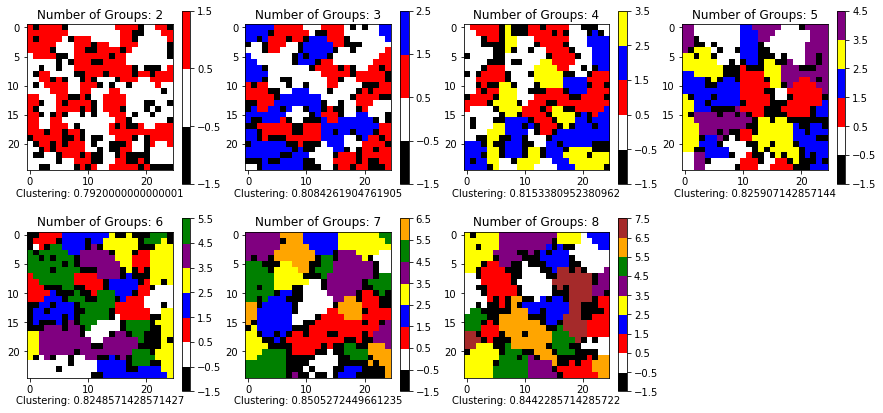

In [36]:
fig = plt.figure(figsize=(15,7))
for j, groups in enumerate(different_versions_of_groups):
    model = SpaceModel(number_of_agents, height, weight, threshold, sd, groups)
    for i in range(100):
        model.step()
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    agent_counts = agent_counts-1
    for cell in model.grid.coord_iter():
        agent_present, x, y = cell
        if agent_present:
            agent_counts[x][y] = groups.index(agent_present.group_membership)
    cmap = colors.ListedColormap(all_colors[:len(groups)+1])
    bounds=[element + 0.5 for element in list(range(-2,len(groups)))]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    plt.subplot(2, 4, j+1)
    plt.imshow(agent_counts, cmap=cmap, norm=norm)
    clust = get_clustering(model, groups)
    plt.text(12, 29, "Clustering: " + str(clust), horizontalalignment='center')
    plt.title("Number of Groups: " + str(len(groups)))
    plt.colorbar()

If you compare this results from this one, compared the the upper one, then you can see that the clustering in the groups is much more dependend on the wish to be with similar people to oursleves, than to not have a majority of some other group. 

## Network Thresholds

Sure, uprooting the entire social netowrk to try something else is not very convincing. So, would we get different results, if it is changing just one member of the network. So fir the end, I will try to replicate the threshold example, but with the network structure. 

For this, I need to change the model and agents. In the model, I deleted everything about space and added a call for function, that creates the original connections.

In [37]:
thresholds = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sd = 0.0
number_of_agents = 50

In [38]:
class NetworkModel(Model):
    def __init__(self, N, threshold, sd, groups):
        self.num_agents = N
        self.schedule = RandomActivation(self)
    
        for i in range(N):
            a = ProgrammerNetwork(i, self, threshold, sd, groups)
            self.schedule.add(a)
        
        #Create connections to agents
        for agent in self.schedule.agents:
            agent.create_connections()
            
    def step(self):
        self.schedule.step()

Here I again deleted everything, that has to do with space, and added things about network connection. 

In [39]:
class ProgrammerNetwork(Agent):
    
    def __init__(self, unique_id, model, threshold, sd, possible_groups):
        super().__init__(unique_id, model)
        self.name = unique_id
        self.group_membership = random.choice(possible_groups)
        self.threshold = random.gauss(threshold, sd)
        if self.threshold > 1:
            self.threshold = 1
        if self.threshold < 0:
            self.threshold = 0
        self.connections = set()
    
    def create_connections(self):
        #the function that creates 10 random connections to other people
        while len(self.connections) < 10:
            agent_to_be_in_relationship = random.choice(self.model.schedule.agents)
            if agent_to_be_in_relationship != self:
                self.connections.add(random.choice(self.model.schedule.agents))
        
    def step(self):
        #here, we first check the ratio of people, that are different then the agent
        all_group_members = [element.group_membership for element in self.connections]
        number_of_nearby_people = len(all_group_members)
        other_people = [element for element in all_group_members if element == self.group_membership]
        #if the person is not satisfied with their position, then they remove a random friend from their network
        #and then they add a random friend
        if len(other_people)/number_of_nearby_people > self.threshold:
            self.connections.pop()
            picked = False
            while picked != True:
                agent_to_be_in_relationship = random.choice(self.model.schedule.agents)
                if agent_to_be_in_relationship != self and agent_to_be_in_relationship not in self.connections:
                    self.connections.add(agent_to_be_in_relationship)
                    picked = True

Now, let us run the model for different thresholds, vizualize it and see.

/usr/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


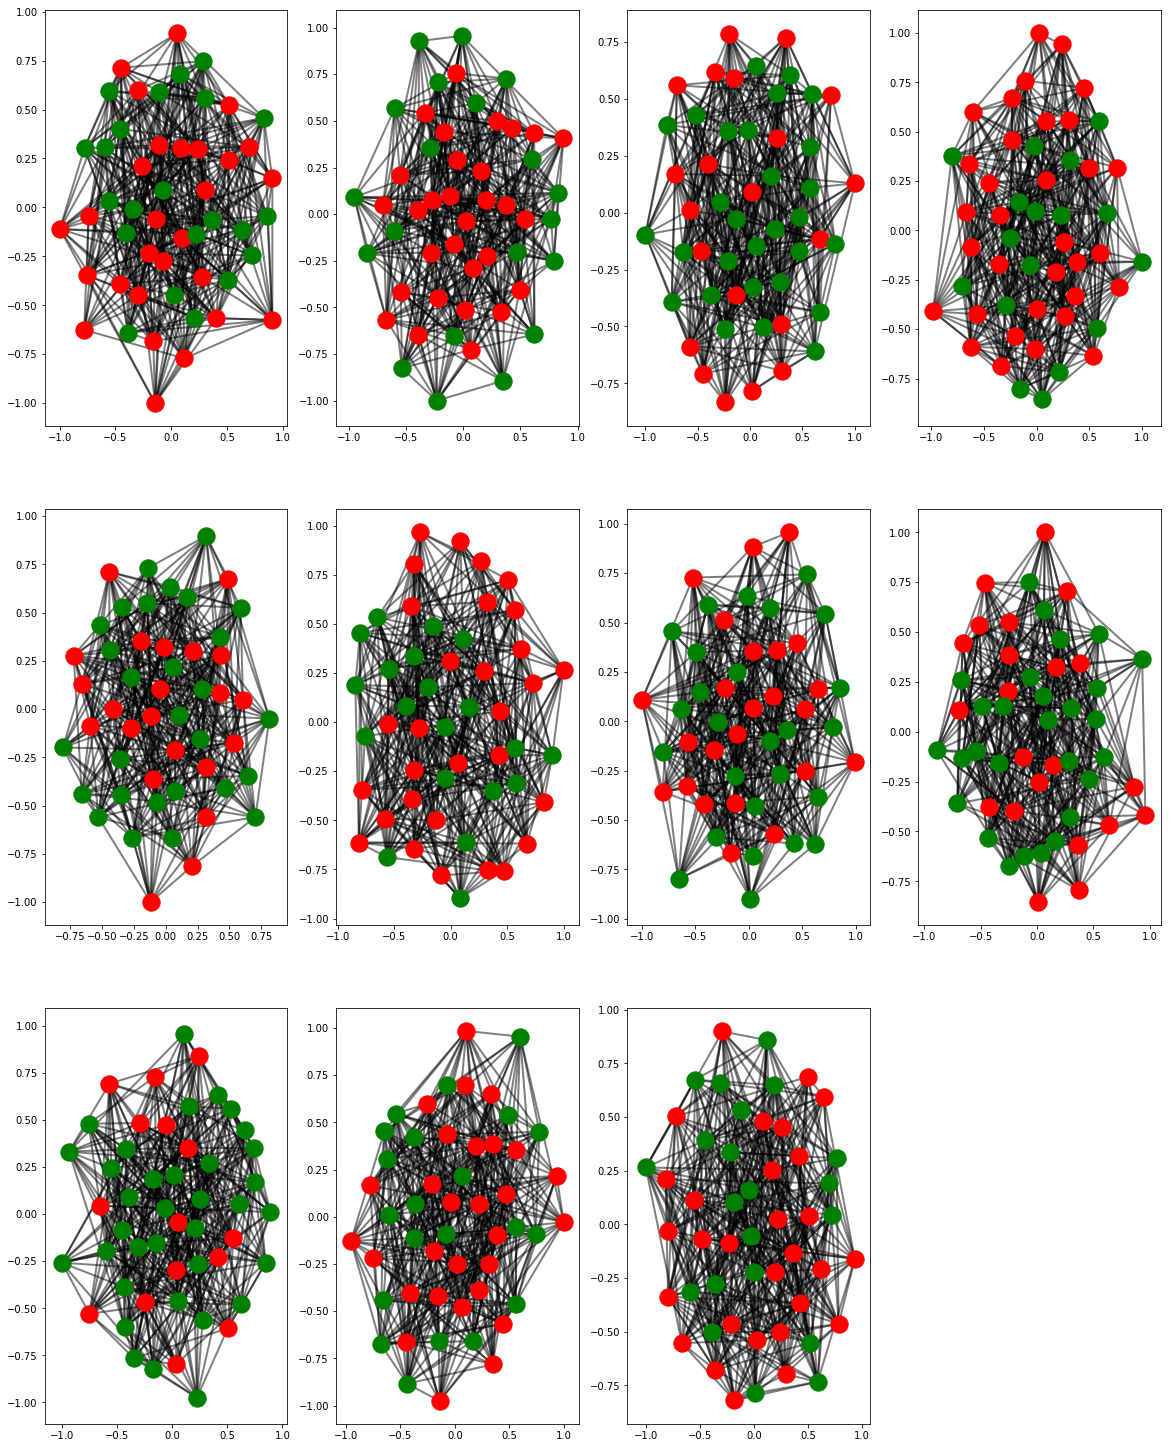

In [40]:
fig = plt.figure(figsize=(20,26))
for j, threshold in enumerate(thresholds):
    model = NetworkModel(number_of_agents, threshold, sd, possible_groups)
    for i in range(100):
        model.step()
    relationships = []
    for a in model.schedule.agents:
        for node in a.connections:
            relationships.append((a.name, node.name))
    G = nx.Graph()
    G.add_nodes_from([a.name for a in model.schedule.agents if a.group_membership == "Vim"], group="Vim")
    G.add_nodes_from([a.name for a in model.schedule.agents if a.group_membership == "Emacs"], group="Emacs")
    G.add_edges_from(relationships)
    plt.subplot(3, 4, j+1)
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=[node[0] for node in G.nodes(data=True) if node[1]["group"] == "Vim"],
                           node_color="red",
                           )
    nx.draw_networkx_nodes(G,
                           pos,
                           nodelist=[node[0] for node in G.nodes(data=True) if node[1]["group"] == "Emacs"],
                           node_color="green"
                      )
    nx.draw_networkx_edges(G,pos,
                       edgelist=G.edges(),
                       width=2,
                       alpha=0.5,
                      )

But of course, I don't know anything about the network analysis yet, so I can't tell if there are any difference. 

## Literature

* Carnahan, T., & McFarland, S. (2007). Revisiting the Stanford Prison Experiment: Could participant self-selection have led to the cruelty?. Personality and Social Psychology Bulletin, 33(5), 603-614.
* Frank, R. H., Gilovich, T., & Regan, D. T. (1993). Does studying economics inhibit cooperation?. Journal of economic perspectives, 7(2), 159-171.
* Schelling, T. C. (1971). Dynamic models of segregation. Journal of mathematical sociology, 1(2), 143-186.